In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/tri_rand1/GxC1.txt", anno_dir = "./data/symsim2/tri_rand1/cell_label1.txt", anchor = "6_2")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/tri_rand1/RxC2.txt", anno_dir = "./data/symsim2/tri_rand1/cell_label2.txt", anchor = "6_2")

In [3]:
fig_dir = "./result/symsim2/tri_rand1/model1/"
use_quantile = True

In [4]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 64, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 256, 64, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

In [5]:
train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    _, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    

for data in test_atac_loader:
    _, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    

    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

In [6]:
if use_quantile:
    if Diff1.shape[0] > Diff2.shape[0]:
        reference = Diff1.reshape(-1)
    else:
        reference = Diff2.reshape(-1)

    Diff1 = quantile_norm(Diff1, reference)
    Diff2 = quantile_norm(Diff2, reference)

Diff1 = torch.FloatTensor(Diff1).to(device)
Diff2 = torch.FloatTensor(Diff2).to(device)

In [7]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 1e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 1e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)


In [8]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1] + 2, hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [9]:
# state = torch.load('./saved_model/symsim2/symsim2_tri_rand1.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1] + 2, hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])

In [12]:
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 101, lamb_r1 = 0.5, lamb_r2 = 0.5, dist_mode = "mse")

epoch:  0 RNA recon loss: 13.17354, RNA dist loss: 0.48663 ATAC recon loss: 0.37300, ATAC dist loss: 0.56094
epoch:  10 RNA recon loss: 3.99522, RNA dist loss: 0.26320 ATAC recon loss: 0.09250, ATAC dist loss: 0.22843
epoch:  20 RNA recon loss: 2.16958, RNA dist loss: 0.24349 ATAC recon loss: 0.04213, ATAC dist loss: 0.20171
epoch:  30 RNA recon loss: 1.54362, RNA dist loss: 0.21189 ATAC recon loss: 0.02737, ATAC dist loss: 0.14066
epoch:  40 RNA recon loss: 1.22489, RNA dist loss: 0.17468 ATAC recon loss: 0.01968, ATAC dist loss: 0.10768
epoch:  50 RNA recon loss: 0.99008, RNA dist loss: 0.14609 ATAC recon loss: 0.01503, ATAC dist loss: 0.10875
epoch:  60 RNA recon loss: 0.82279, RNA dist loss: 0.11342 ATAC recon loss: 0.01200, ATAC dist loss: 0.12201
epoch:  70 RNA recon loss: 0.71699, RNA dist loss: 0.11019 ATAC recon loss: 0.01008, ATAC dist loss: 0.10352
epoch:  80 RNA recon loss: 0.63972, RNA dist loss: 0.10774 ATAC recon loss: 0.00826, ATAC dist loss: 0.09889
epoch:  90 RNA reco

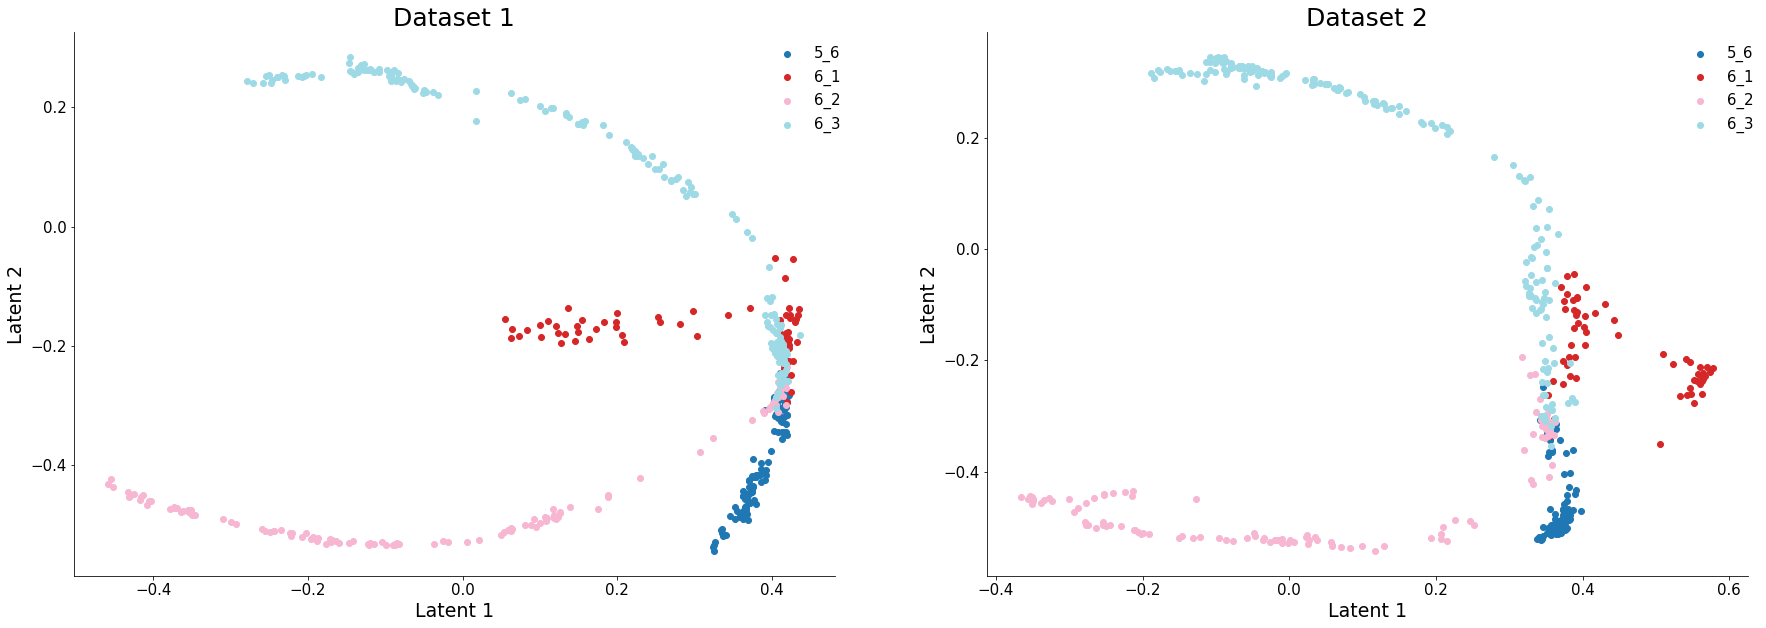

In [19]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None, figsize = (30,10))

In [20]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, fusion = fusion, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 101, use_anchor = False)

epoch:  0 Discriminator loss: 0.68951
epoch:  10 Discriminator loss: 0.65668
epoch:  20 Discriminator loss: 0.60150
epoch:  30 Discriminator loss: 0.52273
epoch:  40 Discriminator loss: 0.42413
epoch:  50 Discriminator loss: 0.31066
epoch:  60 Discriminator loss: 0.24713
epoch:  70 Discriminator loss: 0.20566
epoch:  80 Discriminator loss: 0.17283
epoch:  90 Discriminator loss: 0.14827
epoch:  100 Discriminator loss: 0.16029


In [21]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=151, n_iter=121, n_iter2 = 6, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 1.15454, RNA dist loss: 0.11027 ATAC recon loss: 0.05029, ATAC dist loss: 0.18843 Discriminator loss: 0.78824


KeyboardInterrupt: 

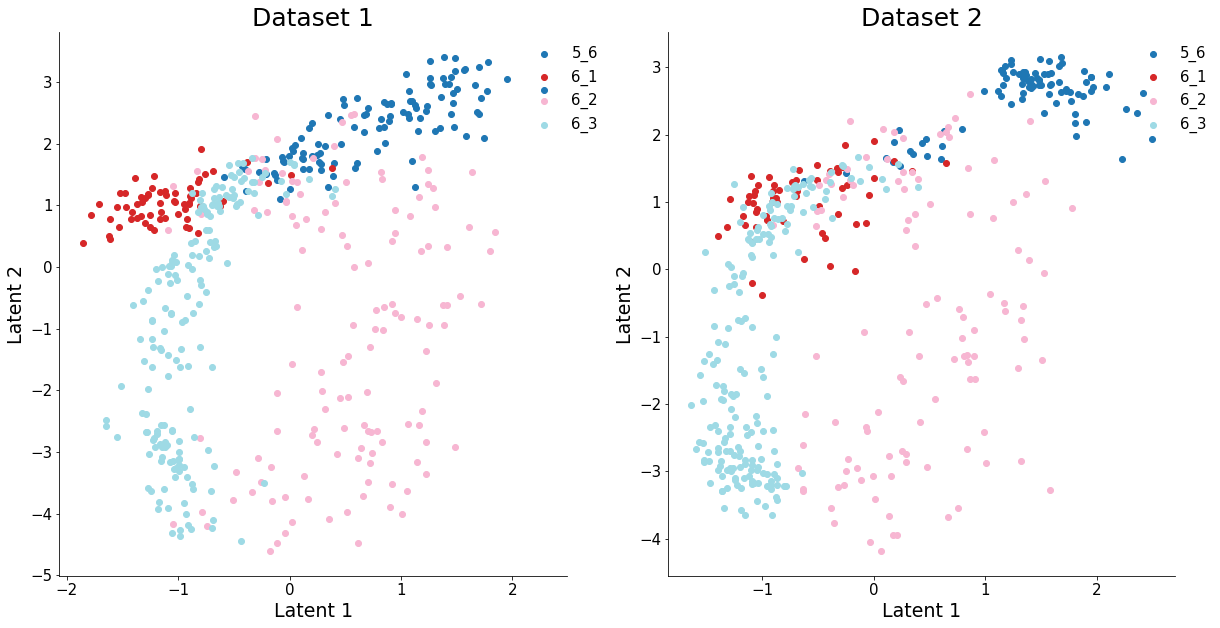

In [14]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save =  fig_dir + "latent_12.png")

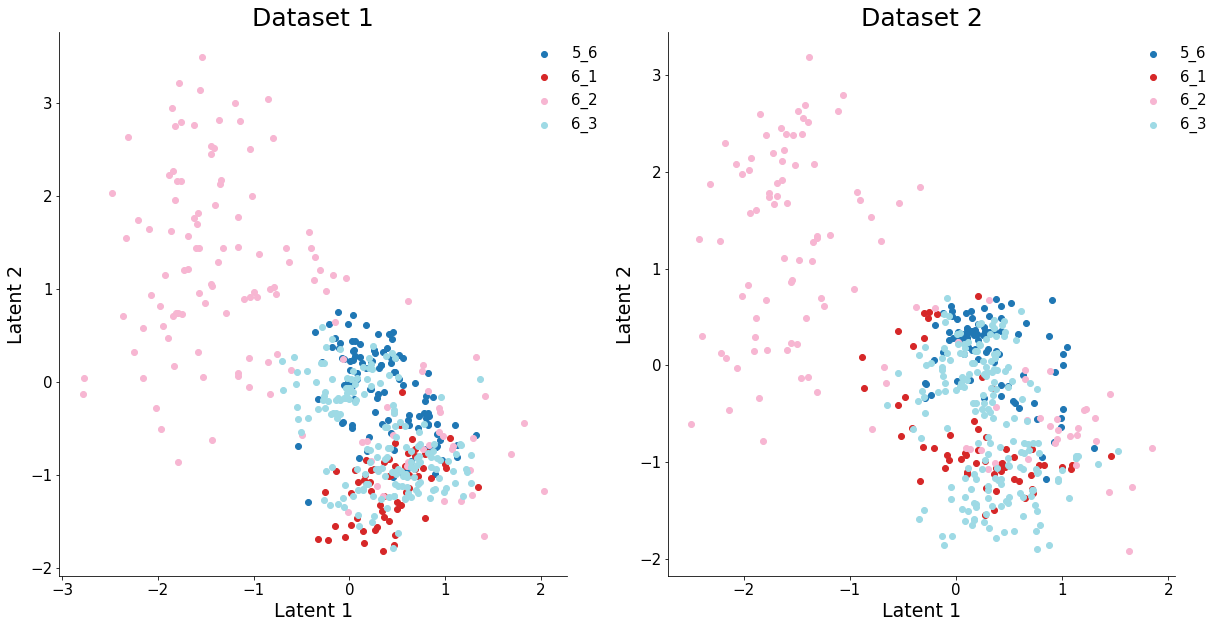

In [10]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir +"latent_34.png")

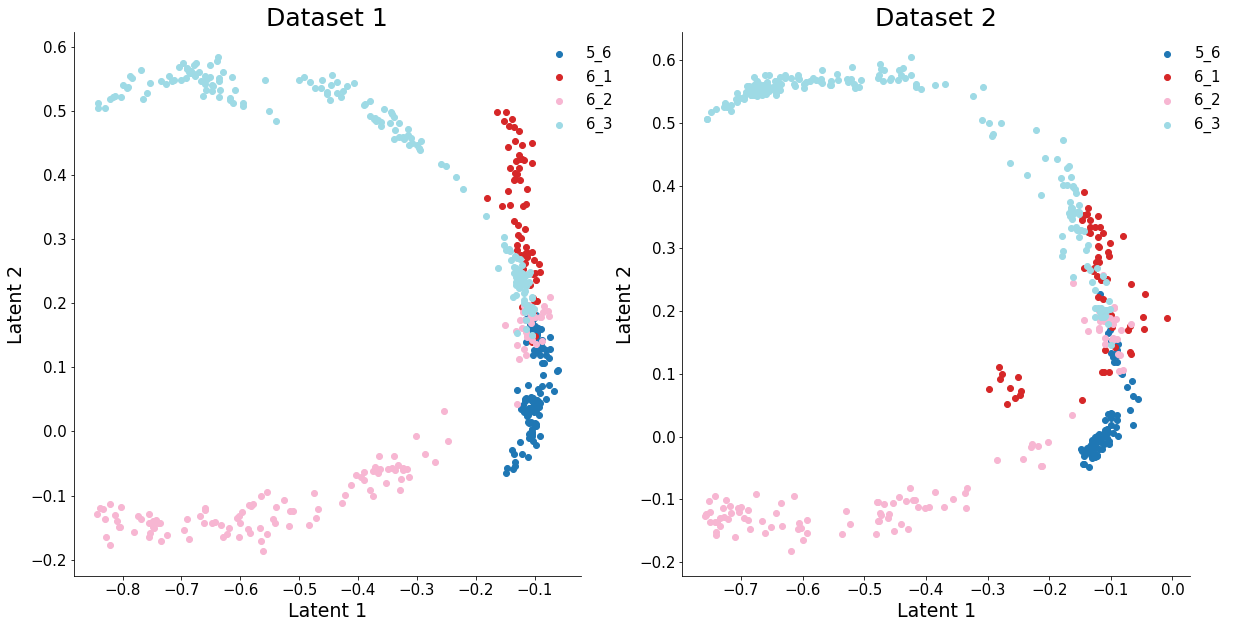

In [11]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir + "deep_separate.png")

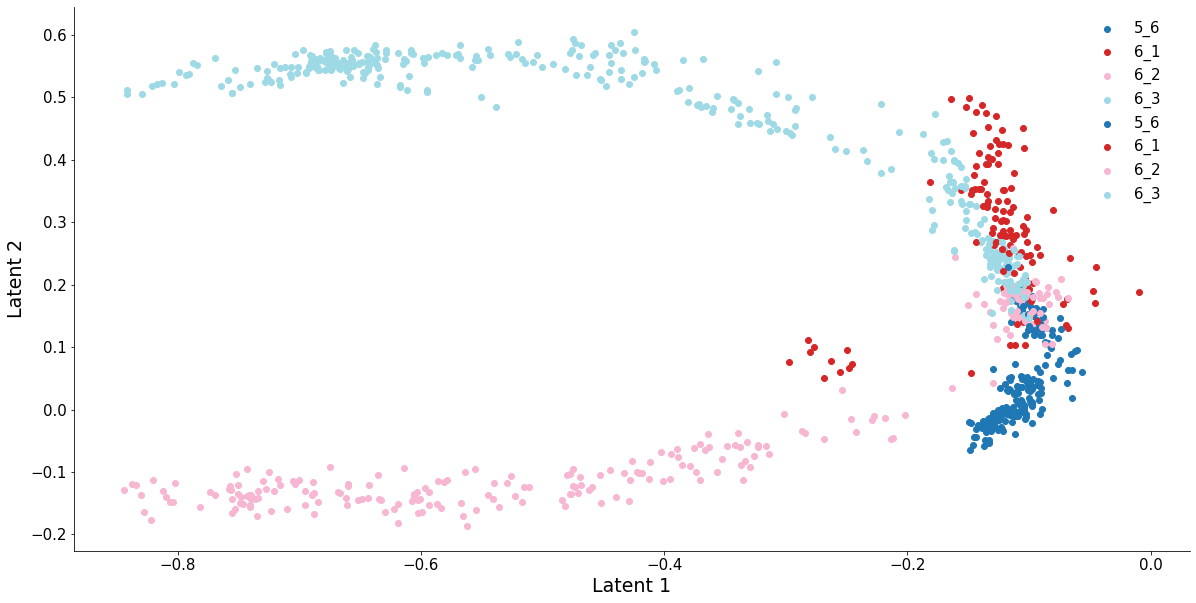

In [12]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = fig_dir + "deep_joint.png")

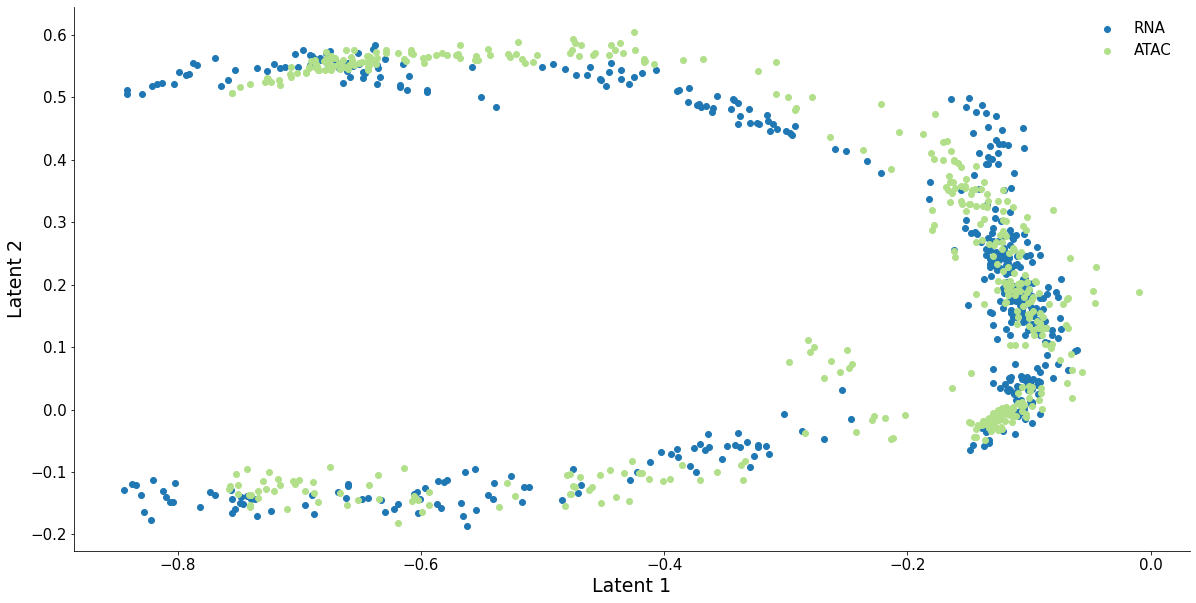

In [13]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = fig_dir + "deep_batch.png")

In [18]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/symsim2/symsim2_tri_rand1_2.pt')